In [1]:
!pip install datasets 
!pip install tokenizers 
!pip install transformers 
!pip install seqeval 
!pip install accelerate
!pip3 install torchinfo

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
from datasets import Dataset, ClassLabel, Sequence, Features, Value, DatasetDict

from transformers import AutoTokenizer

from transformers import DataCollatorForTokenClassification

import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForTokenClassification
import numpy as np
# from datasets import load_metric
import evaluate
from transformers import TrainingArguments, Trainer

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocess

In [3]:
train_data_path = "train.txt"
val_data_path = "valid.txt"
test_data_path = "test.txt"

In [4]:
def read_ner_txt(path):
    with open(path, 'r') as f:
        text = f.readlines()
        text = [i.rstrip('\n') for i in text]
    tokens_list = []
    ner_tags_list = []
    temp_vocab = ''
    temp_label = ''

    for item in text:
        if item == '' or item == '.':  # Empty line or period indicates a new segment
            if temp_vocab:  # Only append if temp_vocab is not empty
                tokens_list.append(temp_vocab)
                ner_tags_list.append(temp_label)
                temp_vocab = ''
                temp_label = ''
        else:
            parts = item.split(' ')
            if len(parts) == 2:  # Ensure the line has both token and label
                vocab, label = parts
                temp_vocab += ' ' + vocab
                temp_label += ' ' + label

    # Append the last segment if it exists
    if temp_vocab:
        tokens_list.append(temp_vocab)
        ner_tags_list.append(temp_label)

    return tokens_list, ner_tags_list

In [5]:
# Read the training data
train_tokens, train_ner_tags = read_ner_txt(train_data_path)

# Read the validation data
val_tokens, val_ner_tags = read_ner_txt(val_data_path)

# Read the test data
test_tokens, test_ner_tags = read_ner_txt(test_data_path)

print(train_tokens[:2])  # Check the first token and its corresponding NER tag
print(train_ner_tags[:2])  # Check the first NER tag

all_tags = []
for tags in train_ner_tags:
    all_tags.extend(tags.strip().split())

tag_name = sorted(set(all_tags))

print(tag_name)

[' The admin@338 has largely targeted organizations involved in financial , economic and trade policy , typically using publicly available RATs such as Poison Ivy , as well some non-public backdoors .', ' The admin@338 started targeting Hong Kong media companies , probably in response to political and economic challenges in Hong Kong and China .']
[' O B-HackOrg O O O O O O B-Idus O B-Idus O B-Idus I-Idus O O O B-Tool I-Tool I-Tool O O B-Tool I-Tool O O O O B-Tool I-Tool O', ' O B-HackOrg O O B-Area I-Area B-Org I-Org O O O O O B-Idus O B-Idus O O B-Area I-Area O B-Area O']
['B-Area', 'B-Exp', 'B-Features', 'B-HackOrg', 'B-Idus', 'B-OffAct', 'B-Org', 'B-Purp', 'B-SamFile', 'B-SecTeam', 'B-Time', 'B-Tool', 'B-Way', 'I-Area', 'I-Exp', 'I-Features', 'I-HackOrg', 'I-Idus', 'I-OffAct', 'I-Org', 'I-Purp', 'I-SamFile', 'I-SecTeam', 'I-Time', 'I-Tool', 'I-Way', 'O']


In [6]:
# === Preprocess to list of list ===
def process_data(tokens_list, tags_list):
    tokens = [s.strip().split() for s in tokens_list]
    tags = [s.strip().split() for s in tags_list]
    return tokens, tags

train_tokens, train_labels = process_data(train_tokens, train_ner_tags)
valid_tokens, valid_labels = process_data(val_tokens, val_ner_tags)
test_tokens, test_labels   = process_data(test_tokens, test_ner_tags)

# === create label map ===
unique_tags = sorted(set(tag for seq in train_labels for tag in seq))
label2id = {t: i for i, t in enumerate(unique_tags)}
id2label = {i: t for t, i in label2id.items()}

In [7]:
train_tokens[0], train_labels[0]  # Check the first token and its corresponding NER tag

(['The',
  'admin@338',
  'has',
  'largely',
  'targeted',
  'organizations',
  'involved',
  'in',
  'financial',
  ',',
  'economic',
  'and',
  'trade',
  'policy',
  ',',
  'typically',
  'using',
  'publicly',
  'available',
  'RATs',
  'such',
  'as',
  'Poison',
  'Ivy',
  ',',
  'as',
  'well',
  'some',
  'non-public',
  'backdoors',
  '.'],
 ['O',
  'B-HackOrg',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Idus',
  'O',
  'B-Idus',
  'O',
  'B-Idus',
  'I-Idus',
  'O',
  'O',
  'O',
  'B-Tool',
  'I-Tool',
  'I-Tool',
  'O',
  'O',
  'B-Tool',
  'I-Tool',
  'O',
  'O',
  'O',
  'O',
  'B-Tool',
  'I-Tool',
  'O'])

In [24]:
test_tokens

[['Kaspersky',
  'believes',
  'both',
  'Shamoon',
  'and',
  'StoneDrill',
  'groups',
  'are',
  'aligned',
  'in',
  'their',
  'interests',
  ',',
  'but',
  'are',
  'two',
  'separate',
  'actors',
  ',',
  'which',
  'might',
  'also',
  'indicate',
  'two',
  'different',
  'groups',
  'working',
  'together',
  '.'],
 ['Indeed',
  ',',
  'Kaspersky',
  'started',
  'tracking',
  'the',
  'BlueNoroff',
  'actor',
  'a',
  'long',
  'time',
  'ago',
  '.'],
 ['Eset\u200d',
  'has',
  'published',
  'a',
  'report',
  'on',
  'the',
  'state-sponsored',
  'Russian',
  'turla',
  'apt',
  'group',
  '\u200d.'],
 ['It',
  'seems',
  'Eset',
  'has',
  'discovered',
  'and',
  'published',
  'on',
  'a',
  'new',
  'malware',
  'module',
  'created',
  'by',
  'Turla',
  '.'],
 ['The',
  'majority',
  'of',
  'NewsBeef',
  'targets',
  'that',
  'Kaspersky',
  'researchers',
  'have',
  'observed',
  'are',
  'located',
  'in',
  'SA',
  '.'],
 ['While',
  'not',
  'directly',
  'o

In [8]:
label2id

{'B-Area': 0,
 'B-Exp': 1,
 'B-Features': 2,
 'B-HackOrg': 3,
 'B-Idus': 4,
 'B-OffAct': 5,
 'B-Org': 6,
 'B-Purp': 7,
 'B-SamFile': 8,
 'B-SecTeam': 9,
 'B-Time': 10,
 'B-Tool': 11,
 'B-Way': 12,
 'I-Area': 13,
 'I-Exp': 14,
 'I-Features': 15,
 'I-HackOrg': 16,
 'I-Idus': 17,
 'I-OffAct': 18,
 'I-Org': 19,
 'I-Purp': 20,
 'I-SamFile': 21,
 'I-SecTeam': 22,
 'I-Time': 23,
 'I-Tool': 24,
 'I-Way': 25,
 'O': 26}

In [9]:
model_name = "jackaduma/SecBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
def tokenize_and_align_labels(examples):
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=128
    )
    aligned_labels = []
    for i, word_labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[word_labels[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        aligned_labels.append(label_ids)
    tokenized["labels"] = aligned_labels
    return tokenized

In [11]:
dataset = DatasetDict({
    "train": Dataset.from_dict({"tokens": train_tokens, "ner_tags": train_labels}),
    "valid": Dataset.from_dict({"tokens": valid_tokens, "ner_tags": valid_labels}),
    "test":  Dataset.from_dict({"tokens": test_tokens,  "ner_tags": test_labels}),
})

dataset = dataset.map(tokenize_and_align_labels, batched=True)
dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# === 建 dataloader ===
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset["train"], batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset["valid"], batch_size=128)
test_loader  = DataLoader(dataset["test"], batch_size=1)

Map:   0%|          | 0/5251 [00:00<?, ? examples/s]

Map: 100%|██████████| 664/664 [00:00<00:00, 10747.16 examples/s]


In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5251
    })
    valid: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 662
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 664
    })
})

In [13]:
import torch
import torch.nn as nn
from torchcrf import CRF
from transformers import AutoModel

class SecBERT_LSTM_CRF(nn.Module):
    def __init__(self, model_name, hidden_dim, tagset_size, bidirectional=False):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim, num_layers=1,
                            batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(lstm_output_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x, _ = self.lstm(x)
        emissions = self.fc(x)
        if labels is not None:
            loss = -self.crf(emissions, labels, mask=attention_mask.bool(), reduction='mean')
            return loss
        else:
            return self.crf.decode(emissions, mask=attention_mask.bool())
        
    def decode(self, input_ids=None, attention_mask=None, **kwargs):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        emissions = self.lstm(outputs)  # 如果你有 LSTM
        tag_seq = self.crf.decode(emissions, mask=attention_mask)
        return tag_seq


In [14]:
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics(predictions, labels, label_names):
    true_predictions = []
    true_labels = []

    for preds, lbls in zip(predictions, labels):
        pred_seq = []
        label_seq = []
        for p, l in zip(preds, lbls):
            if l in label_names:  # 這裡是 label 本身為文字 → 不適用 ID 情況
                pred_seq.append(p)
                label_seq.append(l)
        true_predictions.append(pred_seq)
        true_labels.append(label_seq)

    return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
        "accuracy": accuracy_score(true_labels, true_predictions),
    }

In [15]:
model = SecBERT_LSTM_CRF(model_name, 256, len(label2id)).to("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [16]:
len(label2id)

27

In [17]:
from torchinfo import summary

summary(model, input_data=(torch.ones(2, 128).long().to("cuda"), torch.ones(2, 128).long().to("cuda")))

Layer (type:depth-idx)                                       Output Shape              Param #
SecBERT_LSTM_CRF                                             --                        783
├─BertModel: 1-1                                             [2, 768]                  --
│    └─BertEmbeddings: 2-1                                   [2, 128, 768]             --
│    │    └─Embedding: 3-1                                   [2, 128, 768]             39,936,000
│    │    └─Embedding: 3-2                                   [2, 128, 768]             768
│    │    └─Embedding: 3-3                                   [1, 128, 768]             394,752
│    │    └─LayerNorm: 3-4                                   [2, 128, 768]             1,536
│    │    └─Dropout: 3-5                                     [2, 128, 768]             --
│    └─BertEncoder: 2-2                                      [2, 128, 768]             --
│    │    └─ModuleList: 3-6                                  --              

In [18]:
from tqdm import tqdm
import os

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 20

foler = "bert-lstm-crf"
if not os.path.exists(foler):
    os.makedirs(foler)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    y_true_train, y_pred_train = [], []

    loop = tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training", leave=False)
    for batch in loop:
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["labels"].clone().to("cuda")
        labels[labels == -100] = 0

        preds = model(input_ids, attention_mask)
        loss = model(input_ids, attention_mask, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

        for i in range(len(labels)):
            true_seq = []
            pred_seq = []
            for j in range(len(labels[i])):
                if batch["labels"][i][j].item() != -100:
                    true_seq.append(id2label[batch["labels"][i][j].item()])
                    pred_seq.append(id2label[preds[i][j]])
            y_true_train.append(true_seq)
            y_pred_train.append(pred_seq)

    train_metrics = compute_metrics(
        predictions=y_pred_train,
        labels=y_true_train,
        label_names=[id2label[i] for i in range(len(id2label))]
    )

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_metrics["accuracy"])
    print(f"[Epoch {epoch+1}] Train Loss: {train_losses[-1]:.4f} | Accuracy: {train_metrics['accuracy']:.4f} | Precision: {train_metrics['precision']:.4f} | Recall: {train_metrics['recall']:.4f} | F1: {train_metrics['f1']:.4f}")

    model.eval()
    y_true, y_pred = [], []
    val_loss = 0

    loop = tqdm(valid_loader, desc=f"[Epoch {epoch+1}] Validating", leave=False)
    for batch in loop:
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["labels"].to("cuda")

        tmp_labels = labels.clone()
        tmp_labels[tmp_labels == -100] = 0
        with torch.no_grad():
            preds = model(input_ids, attention_mask)
            loss = model(input_ids, attention_mask, tmp_labels)
            val_loss += loss.item()

        for i in range(len(labels)):
            true_seq = []
            pred_seq = []
            for j in range(len(labels[i])):
                if labels[i][j] != -100:
                    true_seq.append(id2label[labels[i][j].item()])
                    pred_seq.append(id2label[preds[i][j]])
            y_true.append(true_seq)
            y_pred.append(pred_seq)

    metrics = compute_metrics(
        predictions=y_pred,
        labels=y_true,
        label_names=[id2label[i] for i in range(len(id2label))]
    )

    val_losses.append(val_loss / len(valid_loader))
    val_accuracies.append(metrics["accuracy"])

    print(f'[Epoch {epoch+1}] Val Loss: {val_losses[-1]:.4f} | Accuracy: {metrics["accuracy"]:.4f} | Precision: {metrics["precision"]:.4f} | Recall: {metrics["recall"]:.4f} | F1: {metrics["f1"]:.4f}')

    # === 每 10 個 epoch 存一次模型 ===
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"{foler}/model_epoch_{epoch+1}.pt")
        print(f"💾 Saved checkpoint: bert-lstm-crf/model_epoch_{epoch+1}.pt")

# === 儲存最後一個模型 ===
torch.save(model.state_dict(), f"{foler}/model_final.pt")
print("💾 Saved final model: bert-lstm-crf/model_final.pt")

[Epoch 1] Train Loss: 54.3388 | Accuracy: 0.7447 | Precision: 0.0031 | Recall: 0.0011 | F1: 0.0016


[Epoch 1] Val Loss: 42.8535 | Accuracy: 0.8114 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


[Epoch 2] Train Loss: 34.5361 | Accuracy: 0.7789 | Precision: 0.0834 | Recall: 0.0375 | F1: 0.0518


[Epoch 2] Val Loss: 26.6476 | Accuracy: 0.8026 | Precision: 0.0570 | Recall: 0.0355 | F1: 0.0437


[Epoch 3] Train Loss: 24.9113 | Accuracy: 0.7935 | Precision: 0.1845 | Recall: 0.0776 | F1: 0.1092


[Epoch 3] Val Loss: 21.0405 | Accuracy: 0.8242 | Precision: 0.2121 | Recall: 0.1101 | F1: 0.1449


[Epoch 4] Train Loss: 19.6610 | Accuracy: 0.8206 | Precision: 0.3351 | Recall: 0.2029 | F1: 0.2527


[Epoch 4] Val Loss: 17.5867 | Accuracy: 0.8611 | Precision: 0.3655 | Recall: 0.3524 | F1: 0.3588


[Epoch 5] Train Loss: 15.4921 | Accuracy: 0.8586 | Precision: 0.4363 | Recall: 0.3810 | F1: 0.4068


[Epoch 5] Val Loss: 14.3435 | Accuracy: 0.8754 | Precision: 0.4434 | Recall: 0.4063 | F1: 0.4240


[Epoch 6] Train Loss: 12.2429 | Accuracy: 0.8929 | Precision: 0.5212 | Recall: 0.5256 | F1: 0.5234


[Epoch 6] Val Loss: 12.1402 | Accuracy: 0.8956 | Precision: 0.5159 | Recall: 0.5444 | F1: 0.5298


[Epoch 7] Train Loss: 9.7289 | Accuracy: 0.9191 | Precision: 0.6023 | Recall: 0.6376 | F1: 0.6194


[Epoch 7] Val Loss: 11.3723 | Accuracy: 0.8944 | Precision: 0.5086 | Recall: 0.6435 | F1: 0.5681


[Epoch 8] Train Loss: 7.7586 | Accuracy: 0.9369 | Precision: 0.6662 | Recall: 0.7235 | F1: 0.6937


[Epoch 8] Val Loss: 9.4441 | Accuracy: 0.9161 | Precision: 0.5911 | Recall: 0.6757 | F1: 0.6306


[Epoch 9] Train Loss: 6.1043 | Accuracy: 0.9536 | Precision: 0.7396 | Recall: 0.7917 | F1: 0.7648


[Epoch 9] Val Loss: 9.1766 | Accuracy: 0.9096 | Precision: 0.5875 | Recall: 0.7255 | F1: 0.6492


[Epoch 10] Train Loss: 5.1932 | Accuracy: 0.9605 | Precision: 0.7797 | Recall: 0.8272 | F1: 0.8027


[Epoch 10] Val Loss: 8.2055 | Accuracy: 0.9215 | Precision: 0.6447 | Recall: 0.7480 | F1: 0.6925
💾 Saved checkpoint: bert-lstm-crf/model_epoch_10.pt


[Epoch 11] Train Loss: 4.2042 | Accuracy: 0.9716 | Precision: 0.8408 | Recall: 0.8763 | F1: 0.8582


[Epoch 11] Val Loss: 7.7211 | Accuracy: 0.9244 | Precision: 0.6695 | Recall: 0.7586 | F1: 0.7113


[Epoch 12] Train Loss: 3.5751 | Accuracy: 0.9759 | Precision: 0.8671 | Recall: 0.8957 | F1: 0.8812


[Epoch 12] Val Loss: 7.1609 | Accuracy: 0.9331 | Precision: 0.6989 | Recall: 0.7697 | F1: 0.7326


[Epoch 13] Train Loss: 2.8958 | Accuracy: 0.9812 | Precision: 0.8934 | Recall: 0.9155 | F1: 0.9043


[Epoch 13] Val Loss: 6.8084 | Accuracy: 0.9378 | Precision: 0.7210 | Recall: 0.7867 | F1: 0.7524


[Epoch 14] Train Loss: 2.4042 | Accuracy: 0.9848 | Precision: 0.9124 | Recall: 0.9310 | F1: 0.9216


[Epoch 14] Val Loss: 6.7845 | Accuracy: 0.9383 | Precision: 0.7318 | Recall: 0.7904 | F1: 0.7600


[Epoch 15] Train Loss: 2.1359 | Accuracy: 0.9870 | Precision: 0.9262 | Recall: 0.9413 | F1: 0.9337


[Epoch 15] Val Loss: 6.6079 | Accuracy: 0.9414 | Precision: 0.7429 | Recall: 0.8065 | F1: 0.7734


[Epoch 16] Train Loss: 1.8548 | Accuracy: 0.9892 | Precision: 0.9385 | Recall: 0.9513 | F1: 0.9449


[Epoch 16] Val Loss: 6.6583 | Accuracy: 0.9386 | Precision: 0.7208 | Recall: 0.8075 | F1: 0.7617


[Epoch 17] Train Loss: 1.5952 | Accuracy: 0.9908 | Precision: 0.9479 | Recall: 0.9585 | F1: 0.9532


[Epoch 17] Val Loss: 6.7346 | Accuracy: 0.9401 | Precision: 0.7334 | Recall: 0.8047 | F1: 0.7674


[Epoch 18] Train Loss: 1.5013 | Accuracy: 0.9908 | Precision: 0.9451 | Recall: 0.9584 | F1: 0.9517


[Epoch 18] Val Loss: 6.6183 | Accuracy: 0.9410 | Precision: 0.7396 | Recall: 0.7992 | F1: 0.7682


[Epoch 19] Train Loss: 1.3832 | Accuracy: 0.9917 | Precision: 0.9518 | Recall: 0.9630 | F1: 0.9574


[Epoch 19] Val Loss: 6.7404 | Accuracy: 0.9457 | Precision: 0.7721 | Recall: 0.7959 | F1: 0.7839


[Epoch 20] Train Loss: 1.2466 | Accuracy: 0.9927 | Precision: 0.9598 | Recall: 0.9670 | F1: 0.9634


[Epoch 20] Val Loss: 6.7151 | Accuracy: 0.9406 | Precision: 0.7330 | Recall: 0.8130 | F1: 0.7709
💾 Saved checkpoint: bert-lstm-crf/model_epoch_20.pt
💾 Saved final model: bert-lstm-crf/model_final.pt


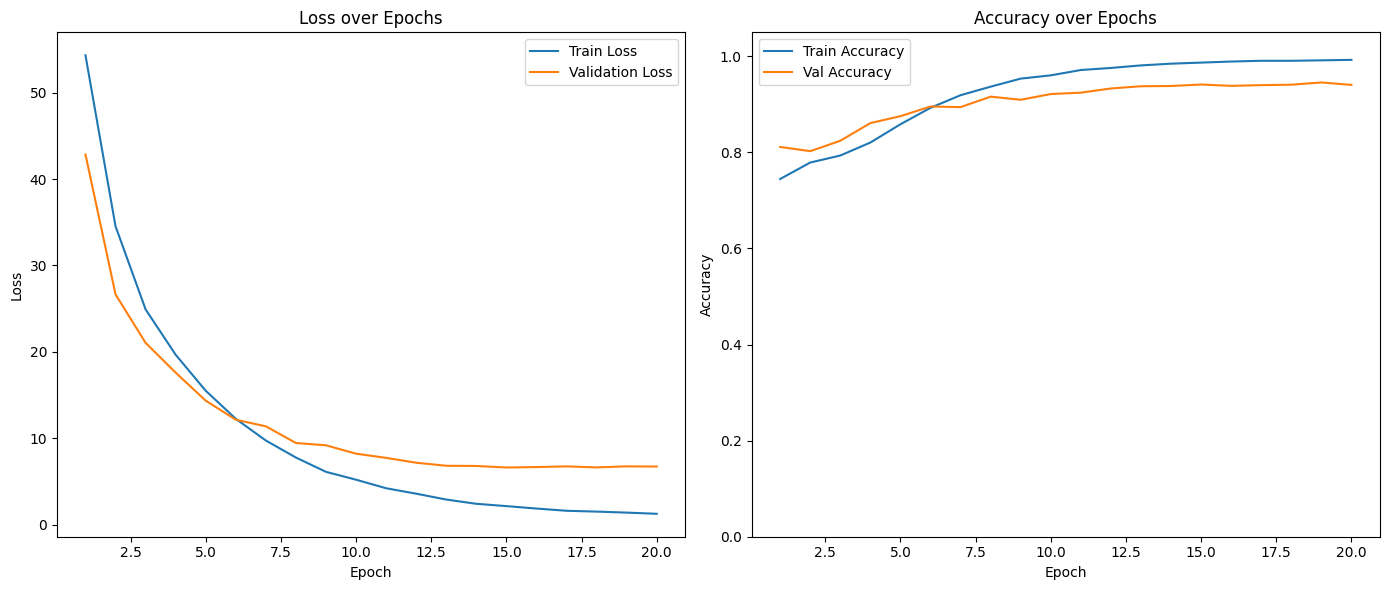

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Loss 圖
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy 圖
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs + 1), val_accuracies, label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
y_true, y_pred = [], []

test_loop = tqdm(test_loader, desc="[Test] Predicting", leave=False)

for batch in test_loop:
    input_ids = batch["input_ids"].to("cuda")
    attention_mask = batch["attention_mask"].to("cuda")
    labels = batch["labels"].to("cuda")
    
    with torch.no_grad():
        preds = model(input_ids, attention_mask)

    for i in range(len(labels)):
        true_seq = []
        pred_seq = []
        for j in range(len(labels[i])):
            if labels[i][j] != -100:
                true_seq.append(id2label[labels[i][j].item()])
                pred_seq.append(id2label[preds[i][j]])

        y_true.append(true_seq)
        y_pred.append(pred_seq)


metrics = compute_metrics(
    predictions=y_pred, 
    labels=y_true,       
    label_names=[id2label[i] for i in range(len(id2label))]
)

print(f"Precision: {metrics['precision']:.5f}")
print(f"Recall:    {metrics['recall']:.5f}")
print(f"F1 Score:  {metrics['f1']:.5f}")
print(f"Accuracy:  {metrics['accuracy']:.5f}")


Precision: 0.79913
Recall:    0.85976
F1 Score:  0.82834
Accuracy:  0.95421


In [ ]:
with open("predicted_test_secbert_lstm_crf.txt", "w", encoding="utf-8") as f:
    for tokens, labels in zip(test_tokens, y_pred):  # y_pred 是 pred_seq
        for token, label in zip(tokens, labels):
            f.write(f"{token} {label}\n")
        f.write("\n")  # 每句話後空一行